# Magnetoelastično Duffingovo nihalo #

In [9]:
# uvoz potrebnih knjižnic
import numpy as np
from scipy.integrate import odeint, quad
from scipy.optimize import brentq
import scipy.signal
from tqdm.notebook import tqdm_notebook
from time import sleep
import cmath
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation, rc
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# nastavitev grafov
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower
plt.rcParams.update({'text.usetex': True,
                     'font.size': 15})

## Uvod ##

### Ozadje problema ###

**Moon in Holmes [[1]](#Viri)** sta Duffingov nelinearni sistem  uresničila kot bistabilno magnetoelastično mehansko nihalo prikazano na *sliki 1*.

<figure>
    <img src="Slike/sistem_shema.png" style="text-align: center" width = 450 alt="shema">
    <figcaption style="text-align: center" name = "my-fig-ref">
        <b> Slika 1: Magnetoelastično nihalo [2]</b>
    </figcaption>
</figure>


Gre za nihajoč konzolno vpeti nosilec, ki se nahaja med dvema permanentnima magnetoma. Magneta vodita v uklon nosilca v eno od dveh lokalno stabilnih leg, definiranimi s pozicijo $x=x(t)$ pri času $t$. Tako imenovana "energijska ponora" ločuje nestabilna lega, ki sovpada z ravnim, nedeformiranim nosilcem pri $x=0$. Sistem vzbujamo z periodično s frekvenco $\omega$ in silo $F=F(t)$.

Gibalna enačba sistema je nelinearna diferencialna enačba drugega reda [[3]](#Viri)

\begin{equation}\label{eq:}
    \ddot x + \delta \dot x - \alpha x + \beta x^3 = \gamma \cos \omega t \, ,
\end{equation}

kjer so parametri $\delta$ dušenje sistema, $\alpha$ linearna togost, $\beta$ nelinearna togost in $\gamma$ amplituda vzbujevalne sile. Duffingova enačba je primer kaotičnega sistema.

In [10]:
# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.20 # sila
omega = 1.2 # frekvenca nihanja

# Začetni pogoji
x0, v0 = 0, 0

Magnetna sila sistemu vnaša potencialno energijo 

\begin{equation}
    V(x)=\beta \frac{x^4}{4} - \alpha \frac{x^2}{2} \, .
\end{equation}

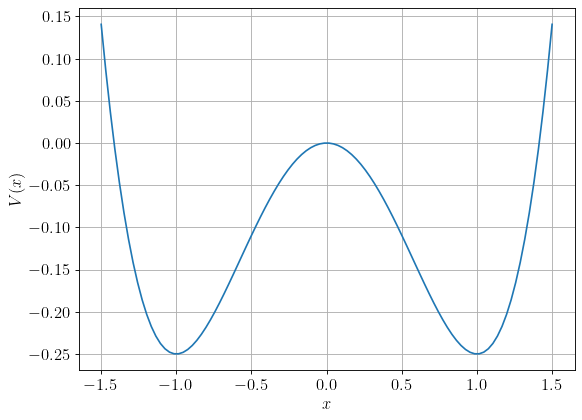

In [11]:
# Potencial in njen prvi odvod
V = lambda x: 0.5 * x**2 * (beta * 0.5 * x**2 - alpha * 1)
dVdx = lambda x: beta * x**3 - alpha * x

# Potencialna energija v odvisnosti od pozicije
xgrid = np.linspace(-1.5, 1.5, 100)
Vgrid = V(xgrid)

fig, ax = plt.subplots(1, 1)
ax.plot(xgrid, Vgrid)
ax.grid(True, linestyle = '-', which='major')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$V(x)$')
plt.show();

### Cilji seminarja ###

V tej nalogi obravnavamo nelinearni sistem, raziščemo vplive parametrov na njegovo dinamiko in rezultate predstavimo skozi različne grafične metode raziskovanja kaotičnosti. 

1. Predstavimo sistem;
2. Sistem rešimo z numeričnim integriranjem gibalne enačbe;
3. Za izbrane fiksne parametre in izbran kontrolni parameter $\gamma$, konstruiramo orbitni diagram in Lyuponov exponent;
4. za izbrane kontrolni parametre $\delta=0.3$, $\alpha=1$, $\beta=1$, $\omega=1.2$ in $0.1 < \gamma < 0.7$ izrišemo časovni graf $x(t)$, fazni diagram in Poincare diagram;
5. Autokorelacijska funkcija;
6. Močnostni spekter;
7. Raziščemo fraktale ksozi dimenzije;
8. Rekonstrukcija signala.

## Numerično reševanje enačbe ##

In [12]:
def deriv(X, t, delta, alpha, beta, gamma, omega):
    """Vrne odvode dx/dt in d2x/dt2."""
    x, xdot = X
    xdotdot = -dVdx(x) - delta * xdot + gamma * np.cos(omega*t)
    return xdot, xdotdot

def JM(X, delta, alpha, beta, gamma, omega):
    """Jakobijeva matrika."""
    x, xdot = [k for k in X]
    return np.array([[0, 1], [-beta+3*alpha*x**2, -delta]])

def solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega):
    """
    Reševanje Duffingove enačbe za parametre delta, alfa, beta, gamma in omega.
    
    Poišče numerično rešitev enačbe z ustreznim časovnim korakom:
    - tmax: maksimalni čas do katerega numerično integriramo [s]
    - t_trans: čas do ustaljenega nihanja (do tega časa so rezultati zavrženi)
    - dt_per_period: število časovnih točk (trajanja dt), ki so vključene na posamezni periodi (frekvenca omega)
    
    Vrne čas t (po tranzientnem nihanju), pozicijo x in hitrost xdot, ter dt in korak (število točk na periodo). 

    """
    # časovni razmak in časovni korak
    period = 2*np.pi/omega
    dt = 2*np.pi/omega / dt_per_period
    step = int(period / dt)
    t = np.arange(0, tmax, dt)
    # začetni pogoji: x, xdot
    X0 = [x0, v0]
    X = odeint(deriv, X0, t, args=(delta, alpha, beta, gamma, omega))
    idx = int(t_trans / dt)
    return t[idx:], X[idx:], dt, step


def lyapunov_eksponent(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega):
    """Izračun Lyapunovega eksponenta."""
    U = np.eye(2) #začetni volumen
    X0 = [x0, v0] #začetni pogoji
    lyap = [] #seznam ortogonalnih vektorjev (Lyapunov eksponent)

    # časovni razmak in časovni korak
    period = 2*np.pi/omega
    dt = 2*np.pi/omega/dt_per_period
    step = int(period/dt)
    iters = int(tmax/dt)
    t = np.arange(0, tmax, dt)

    #integrate the ODE system -- hopefully falls into an attractor
    X_n = odeint(deriv, X0, t, args=(delta, alpha, beta, gamma, omega))

    #po vsaki iteraciji:
    for k in range(0, iters):
        X0 = X_n[k] #nov v0 po vsaki iteraciji
        U_n = np.matmul(np.eye(2) + JM(X0, delta, alpha, beta, gamma, omega) * dt, U)

        #Gram-Schmidt Ortogonalizacija (GSO)
        Q, R = np.linalg.qr(U_n)
        lyap.append(np.log(abs(R.diagonal())))

        U = Q #nov vektor po iteraciji

    return [sum([lyap[k][j] for k in range(iters)]) / (dt * iters) for j in range(2)]

## Raziskovanje parametričnega prostora ##

### Bifurkacijski diagram $x^*(\gamma)$ ###

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

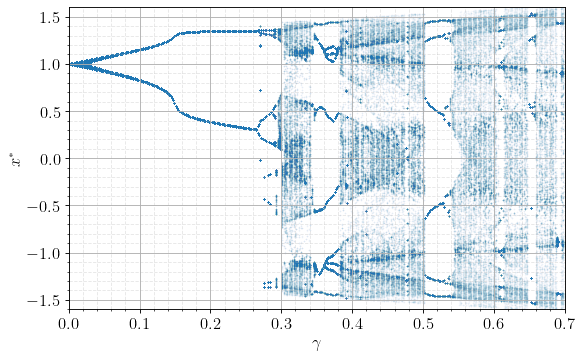

In [8]:
# maksimalni čas, transientni čas
t_trans, tmax = 500, 1800
dt_per_period = 100 # korak na periodo

# Reševanje gibalne enačbe za vsak gamma
gamma_range = np.linspace(0.0, 0.7, 400)
x_range = np.array([])
for i in tqdm_notebook(range(len(gamma_range))):
    t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma_range[i], omega)
    x, xdot = X.T
    for j in range(len(x)):
        if not np.abs(xdot[j])<0.05:
            x[j] = -100
    x_range = np.append(x_range, x)
x_range = x_range.reshape(len(gamma_range), len(x))

# Izris
plt.figure(figsize=(8,5))
for i in tqdm_notebook(range(len(gamma_range))):
    xe = gamma_range[i]
    ye = x_range[i]
    plt.scatter([xe] * len(ye), ye, c='#1f77b4', s=0.01, alpha=0.2)
plt.xlim(0.0, 0.7)
plt.ylim(-1.6, 1.6)
plt.ylabel(r'$x^*$')
plt.xlabel(r'$\gamma$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)
plt.show();

### Lyapunov eksponent $\lambda(\gamma)$ ###

#### Lyapunov eksponent  $\delta(\gamma)$ ####

  0%|          | 0/400 [00:00<?, ?it/s]

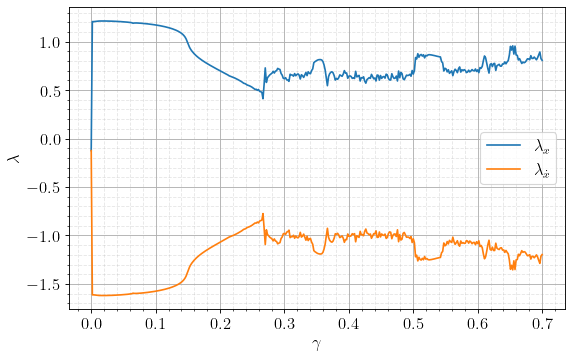

In [50]:
# maksimalni čas, transientni čas
tmax = 500
dt_per_period = 100 # korak na periodo

# Reševanje gibalne enačbe za vsak gamma
gamma_range = np.linspace(0.0, 0.7, 400)
lambda_x_range = np.array([])
lambda_xdot_range = np.array([])
for i in tqdm_notebook(range(len(gamma_range))):
    lambda_x, lambda_xdot = lyapunov_eksponent(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma_range[i], omega)
    lambda_x_range = np.append(lambda_x_range, lambda_x)
    lambda_xdot_range = np.append(lambda_xdot_range, lambda_xdot)
    
# Izris
plt.figure(figsize=(8,5))
plt.plot(gamma_range, lambda_x_range, label=r'$\lambda_{x}$')
plt.plot(gamma_range, lambda_xdot_range, label=r'$\lambda_{\dot x}$')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$\gamma$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)
plt.legend()
plt.show();

  0%|          | 0/400 [00:00<?, ?it/s]

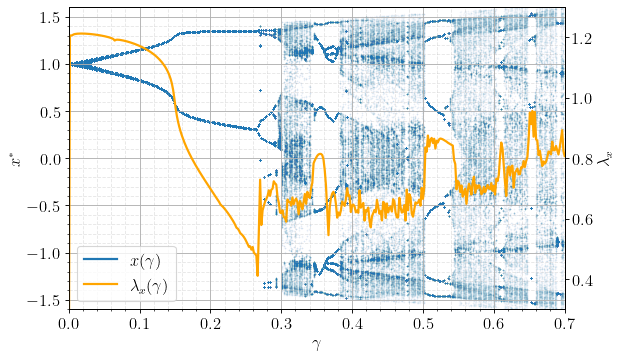

In [51]:
from matplotlib.lines import Line2D

plt.figure(figsize=(8,5))

ax1 = plt.subplot()
for i in tqdm_notebook(range(len(gamma_range))):
    xe = gamma_range[i]
    ye = x_range[i]
    ax1.scatter([xe] * len(ye), ye, c='#1f77b4', s=0.01, alpha=0.2)
ax1.set_xlim(0.0, 0.7)
ax1.set_ylim(-1.6, 1.6)
ax1.set_xlabel(r'$\gamma$')
ax1.set_ylabel(r'$x^*$')

ax2 = ax1.twinx()
ax2.plot(gamma_range, lambda_x_range, c='orange', lw=2)
ax2.set_ylim(0.3, 1.3)
ax2.set_ylabel(r'$\lambda_x$')

ax1.grid(True)
ax1.grid(True, which='minor', linestyle = '--', alpha=0.3)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

custom_lines = [Line2D([0], [0], color='#1f77b4', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax1.legend(custom_lines, [r'$x(\gamma)$', r'$\lambda_x(\gamma)$'], loc=3)
plt.show()

#### Lyapunov eksponent  $\delta(\gamma, \, \omega)$ ####

In [104]:
# maksimalni čas, transientni čas
tmax = 500
dt_per_period = 100 # korak na periodo

# Reševanje gibalne enačbe za vsak gamma in omega
gamma_range = np.linspace(0.0, 0.7, 50)
omega_range = np.linspace(0.1, 1.4, 50)
x_range = np.zeros((len(gamma_range), len(omega_range)))
xdot_range = np.zeros((len(gamma_range), len(omega_range)))

for i in tqdm_notebook(range(len(gamma_range))):
    for j in range(len(gamma_range)):
        x, xdot = lyapunov_eksponent(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma_range[i],  omega_range[j])
        x_range[i,j]=x
        xdot_range[i,j] = xdot

  0%|          | 0/50 [00:00<?, ?it/s]

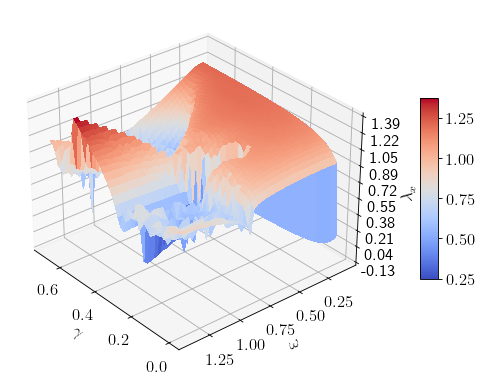

In [131]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Podatki
X, Y = np.meshgrid(gamma_range, omega_range)
Z = x_range

# Izris
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, rcount=200, ccount=200)

# rotate the axes and update
ax.view_init(30, 140)

#ax.set_zlim(0.5, 1.4)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\omega$')
ax.set_zlabel(r'$\lambda_x$')
fig.colorbar(surf, shrink=0.5, aspect=10, pad = 0.1)

plt.show()

## Časovni potek, fazni diagram, Poincaré diagram ##

In [8]:
from ipywidgets import interact
import ipywidgets as widgets

def plot(alpha, beta, gamma, delta, omega, ti):
    # Začetni pogoji
    x0, v0 = 0, 0
    t_trans, tmax = 300, 18000
    dt_per_period = 100

    # parametri - fiksni
    delta = 0.3 # dušenje
    alpha = 1.0 # linearna togost
    beta = 1.0 # nelinearna togost 
    omega = 1.2 # frekvenca nihanja

    # Reševanje enačbe za parametre
    t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
    x, xdot = X.T
    
    # izris
    plt.figure(figsize=(9,9))
    
    # Pozicija kot funkcija časa
    plt.subplot(2,2,(1,2))
    plt.scatter(t[50*ti], x[50*ti], lw=0, c='orange')
    plt.plot(t[0:50*ti], x[0:50*ti])
    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(True)
    plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

    # Fazni diagram
    plt.subplot(223)
    plt.scatter(x[50*ti], xdot[50*ti], lw=0, c='orange')
    plt.plot(x[0:50*ti], xdot[0:50*ti], lw=1)
    plt.xlim(-1.6, 1.6)
    plt.ylim(-1.6, 1.6)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\dot x$')
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(True)
    plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

    # Poincaré diagram
    plt.subplot(224)
    plt.scatter(x[::pstep], xdot[::pstep], s=2, lw=0)
    plt.xlim(-1.6, 1.6)
    plt.ylim(-1.6, 1.6)
    plt.xlabel(r'$x$')
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_ticklabels([])
    plt.grid(True)
    plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

    plt.show()

interact(plot, 
         alpha = widgets.FloatSlider(value=1.0, min=0.0, max=3.0, step=0.1),
         beta = widgets.FloatSlider(value=1.0, min=0.0, max=3.0, step=0.1),
         gamma = widgets.FloatSlider(value=0.32, min=0.0, max=0.7, step=0.01),
         delta = widgets.FloatSlider(value=0.30, min=0.00, max=0.50, step=0.01),
         omega = widgets.FloatSlider(value=1.2, min=0.0, max=1.5, step=0.1),
         ti = widgets.IntSlider(value=50, min=1, max=50, step=1)
        );

interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0), FloatSlider(value=1.0, description…

## Autokorelacijska funkcija ##

Vrednost Cov(epsilon)=1/e je pri tau=103.67255756846318


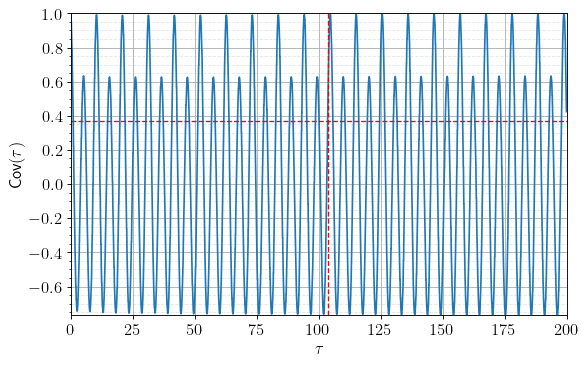

In [13]:
# Začetni pogoji
x0, v0 = 0, 0
tau_max = 200
t_trans, tmax = 0, 12000
dt_per_period = 100

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.28
omega = 1.2 # frekvenca nihanja

# Reševanje enačbe za parametre
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
x, xdot = X.T

### Autokorelacijki koeficient
sigma_x = np.std(x) # standerdna deviacija
sigma_xdot = np.std(xdot)
r = (x-np.mean(x))*(xdot-np.mean(xdot))/(sigma_x*sigma_xdot)

# autokorelacijska funkcija
period = 2*np.pi/omega
dt = 2*np.pi/omega/dt_per_period

tau = np.arange(0, tau_max, dt) #sekunde
covariance = np.array([])

for tau_i in tau:
    tau_N = int(tau_i/dt)
    N = len(x)
    x1 = x[0:N-tau_N]
    x2 = x[tau_N::]
    coveriance_i = ( 1/(N-tau_N) * np.sum((x1*x2 - np.mean(x)**2)) ) / ( 1/(N-1)  * np.sum((x1-np.mean(x))**2) )
    covariance = np.append(covariance, coveriance_i)
    
idx = np.abs(covariance - 1/np.e).argmin()
print(f'Vrednost Cov(epsilon)=1/e je pri tau={tau[idx]}')
    
# izris
plt.figure(figsize=(8,5))
plt.plot(tau, covariance)
plt.axhline(y=covariance[idx], c='r', linestyle='--', lw=1.2, label=r'$\omega$ vzbujanja')
plt.axvline(x=tau[idx], c='r', linestyle='--', lw=1.2, label=r'$\omega$ vzbujanja')
plt.xlabel(r'$\tau$')
plt.ylabel(r'Cov$(\tau)$')
plt.xlim(0,tau_max)
plt.ylim(covariance.min(),covariance.max())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

## Močnostni spekter ##

In [14]:
# Začetni pogoji
x0, v0 = 0, 0
t_trans, tmax = 0, 10**5
dt_per_period = 100
fs = len(x)/(tmax-t_trans)

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.32
omega = 1.2 # frekvenca nihanja

# Reševanje enačbe za parametre
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
x, xdot = X.T

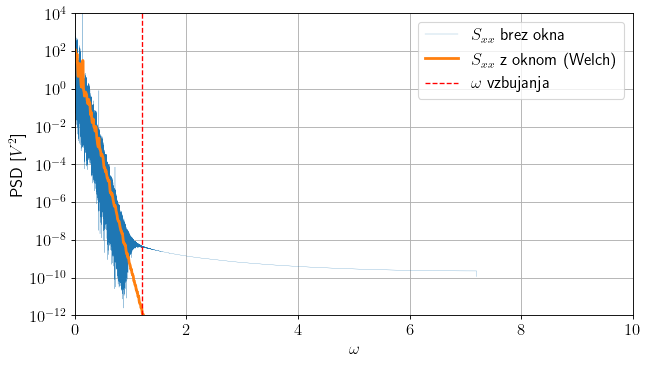

In [19]:
# izračun
(f1, S1) = scipy.signal.periodogram(x, fs, scaling='density')
(f2, S2)= scipy.signal.welch(x, fs, nperseg=1024*4)

# izris
plt.figure(figsize=(9,5))
plt.semilogy(2*np.pi*f1, S1, lw=0.2, label=r'$S_{xx}$ brez okna')
plt.semilogy(2*np.pi*f2, S2, lw=2.5, label=r'$S_{xx}$ z oknom (Welch)')
plt.axvline(x = omega, c='r', linestyle='--', lw=1.2, label=r'$\omega$ vzbujanja')
plt.xlim(0,10)
plt.ylim(10**(-12),10**4)
plt.xlabel(r'$\omega$')
plt.ylabel(r'PSD [$V^2$]')
#plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)
plt.legend()
plt.show()

## Fraktali Duffingove enačbe ##

### Vizualizacija fraktala ###

In [112]:
# Začetni pogoji
x0, v0 = 0, 0
t_trans, tmax = 300, 10.2**7
dt_per_period = 100

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.32
omega = 1.2 # frekvenca nihanja

# Reševanje enačbe za parametre
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
x, xdot = X.T

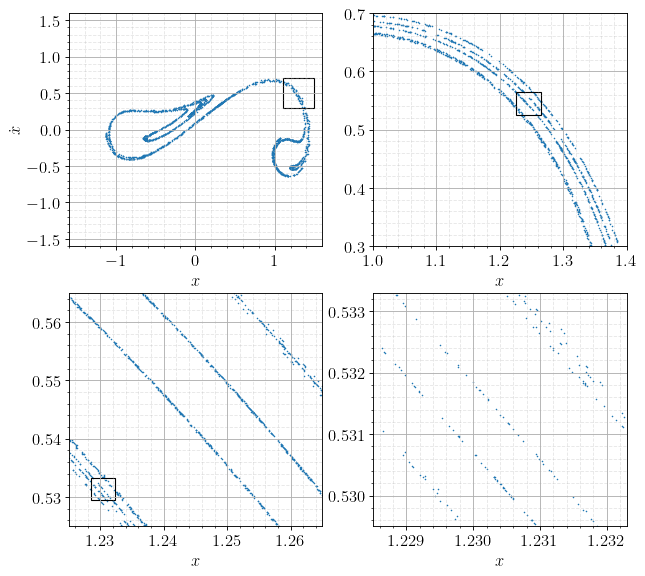

In [113]:
from matplotlib.patches import Rectangle

# izris
plt.figure(figsize=(9,8.5))

# Poincaré diagram 1
plt.subplot(221)
plt.scatter(x[::pstep*2**10], xdot[::pstep*2**10], s=2, lw=0)
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
pozx=1.0
pozy=0.3
plt.gca().add_patch(Rectangle(xy=(pozx+0.1, pozy), width=0.4, height=0.4, alpha=1, fill=False))
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Poincaré diagram 2
plt.subplot(222)
plt.scatter(x[::pstep*2**6], xdot[::pstep*2**6], s=2, lw=0)
plt.xlim(pozx, pozx+0.4)
plt.ylim(pozy, pozy+0.4)
pozx=1.225
pozy=0.525
plt.gca().add_patch(Rectangle(xy=(pozx, pozy), width=0.04, height=0.04, alpha=1, fill=False))
plt.xlabel(r'$x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Poincaré diagram 3
plt.subplot(223)
plt.scatter(x[::pstep*2**2], xdot[::pstep*2**2], s=2, lw=0)
plt.xlim(pozx, pozx+0.04)
plt.ylim(pozy, pozy+0.04)
pozx=1.2285
pozy=0.5295
plt.gca().add_patch(Rectangle(xy=(pozx, pozy), width=0.0038, height=0.0038, alpha=1, fill=False))
plt.xlabel(r'$x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Poincaré diagram 4
plt.subplot(224)
plt.scatter(x[::pstep], xdot[::pstep], s=2, lw=0)
plt.xlim(pozx, pozx+0.0038)
plt.ylim(pozy, pozy+0.0038)
plt.xlabel(r'$x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

plt.show()

### Dimenzija fraktala ###

#### Metoda škatle $d_B$ ####

D_0=d_B=2.967403230907045
D_0=d_B=0.991893032999343


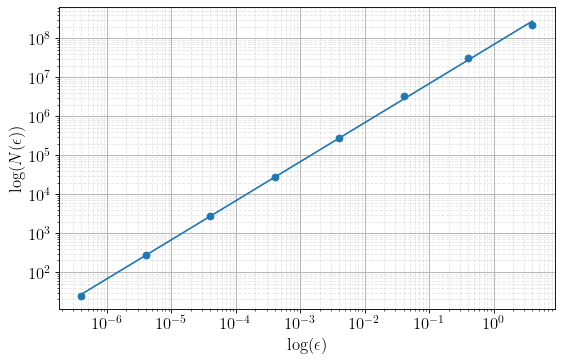

In [149]:
epsilon_box_x0y0 = np.array([[-1.5,-1.5], [-1.0,-1.0], [1.0, 0.3], [1.225, 0.525], [1.2285, 0.5295], [1.229, 0.532], [1.229, 0.532], [1.229, 0.532]])
epsilon = np.array([4.00, 0.4, 0.04, 0.004, 0.0004, 0.00004, 0.000004, 0.0000004])
d_B_range = np.array([])
N_box_range = np.array([])

for i in range(len(epsilon)):
    epsilon_box = np.array([ [epsilon_box_x0y0[i][0], epsilon_box_x0y0[i][0] + epsilon[i]],
                             [epsilon_box_x0y0[i][1], epsilon_box_x0y0[i][0] + epsilon[i]] ])
    N_box = np.where((x > epsilon_box[0,0]) & (x < epsilon_box[0,1]), True, False).sum()
    N_box_range = np.append(N_box_range, N_box)
    
# d_B z linerno regresijo
lin_reg = np.polyfit(np.log(epsilon), np.log(N_box_range), deg=1)
lin_reg_fun = lin_reg[1] + lin_reg[0]*np.log(epsilon)
    
# izris
plt.figure(figsize=(8,5))
plt.loglog(epsilon, N_box_range, color='#1f77b4', linestyle='None', marker='o')
plt.plot(epsilon, np.e**lin_reg_fun, linestyle='-')
plt.xlabel(r'$\log(\epsilon)$')
plt.ylabel(r'$\log(N(\epsilon))$')
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

print(f"D_0=d_B={np.log(lin_reg_fun[0])}")
print(f"D_0=d_B={  (np.log(N_box_range[-1])-np.log(N_box_range[0]))/(np.log(epsilon[-1])-np.log(epsilon[0])) }")

#### Metoda korelacije dimenzij $d_C$ ####

**$C=f(N)$ - ugotavljanje potrebne gostot točk**

In [205]:
# Začetni pogoji
x0, v0 = 0, 0
t_trans, tmax_range = 300, np.array([600, 800, 1000, 1200, 1600, 1800, 2000, 2200])
dt_per_period = 20

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.32
omega = 1.2 # frekvenca nihanja

epsilon = np.array([0.02, 0.002, 0.0002])
correlation_integral_range_N = np.array([]) #(C(N))
N_range_N = np.array([])


for k in tqdm_notebook(range(len(tmax_range))):
    
    # Reševanje enačbe za parametre
    t, X, dt, pstep = solve_duffing(tmax_range[k], dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
    x, xdot = X.T
    
    # Korelacijska funkcija
    correlation_integral = 0
    N = len(x)
    for e in tqdm_notebook(epsilon):
        for i in range(N):
            for j in range(i+1,N): 
                euc_norm = e - np.linalg.norm( np.array([x[i], xdot[i]]) - np.array([x[j], xdot[j]]) )
                correlation_integral += 2*np.heaviside(euc_norm, 0)
            
        correlation_integral_range_N = np.append(correlation_integral_range_N, correlation_integral/N**2) 
        N_range_N = np.append(N_range_N, N)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

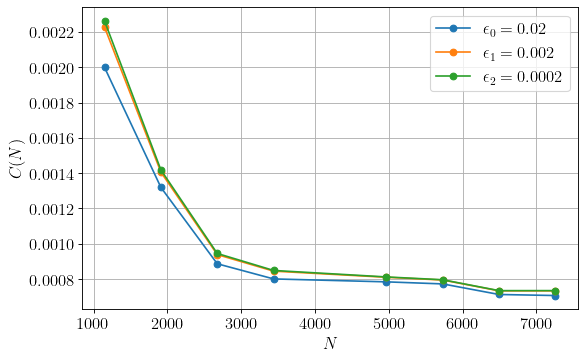

In [206]:
# izris
plt.figure(figsize=(8,5))
for e in range(len(epsilon)):
    plt.plot(N_range_N[e::len(epsilon)], correlation_integral_range_N[e::len(epsilon)], linestyle='-', marker='o', label=f"$\epsilon_{e}={epsilon[e]}$")
plt.xlabel(r'$N$')
plt.ylabel(r'$C(N)$')
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)
plt.legend()
plt.show()

**$C=f(\epsilon)$**

In [221]:
# V odvisnosti od epsilon
# Začetni pogoji
x0, v0 = 0, 0
t_trans, tmax = 300, 1200
dt_per_period = 20

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.32
omega = 1.2 # frekvenca nihanja

epsilon_range = np.array([40, 4.00, 0.4, 0.04, 0.004, 0.0004])
correlation_integral_range_eps = np.array([]) #(C(eps))
N_range_eps = np.array([])


# Reševanje enačbe za parametre
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
x, xdot = X.T

# Korelacijska funkcija za vsak epsilon 
for k in tqdm_notebook(range(len(epsilon_range))):    
    correlation_integral = 0
    N = len(x)
    for i in tqdm_notebook(range(N)):
        for j in range(i+1,N): 
            euc_norm = epsilon_range[k] - np.linalg.norm( np.array([x[i], xdot[i]]) - np.array([x[j], xdot[j]]) )
            correlation_integral += 2*np.heaviside(euc_norm, 0)
            
    correlation_integral_range_eps = np.append(correlation_integral_range_eps, correlation_integral/N**2) 
    N_range_eps = np.append(N_range_eps, N)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

  0%|          | 0/3439 [00:00<?, ?it/s]

D_2=d_C=3.5514839256435313
D_2=d_C=1.28455989923237


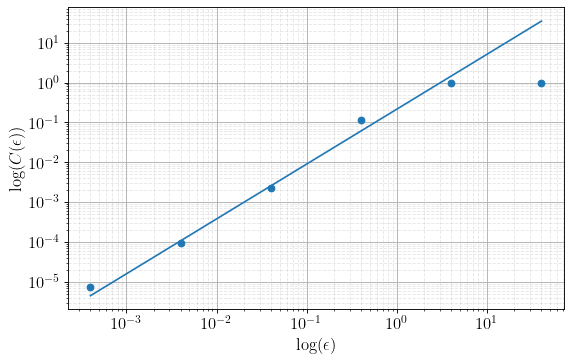

In [229]:
# d_G z linerno regresijo
lin_reg = np.polyfit(np.log(epsilon_range[1:-1]), np.log(correlation_integral_range_eps[1:-1]), deg=1)
lin_reg_fun = lin_reg[1] + lin_reg[0]*np.log(epsilon_range)

# izris
plt.figure(figsize=(8,5))
plt.loglog(epsilon_range, correlation_integral_range_eps, color='#1f77b4', linestyle='None', marker='o')
plt.plot(epsilon_range, np.e**lin_reg_fun, linestyle='-')
plt.xlabel(r'$\log(\epsilon)$')
plt.ylabel(r'$\log(C(\epsilon))$')
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

#print(f"D_2=d_C={lin_reg_fun[0]}")
print(f"D_2=d_C={  (np.log(correlation_integral_range_eps[-1])-np.log(correlation_integral_range_eps[1]))/(np.log(epsilon_range[-1])-np.log(epsilon_range[1])) }")

## Rekonstrukcija atraktorja ##

In [230]:
# Začetni pogoji
x0, v0 = 0, 0
tau_max = 200
t_trans, tmax = 0, 12000
dt_per_period = 100

# parametri - fiksni
delta = 0.3 # dušenje
alpha = 1.0 # linearna togost
beta = 1.0 # nelinearna togost 
gamma = 0.32
omega = 1.2 # frekvenca nihanja

# Reševanje enačbe za parametre
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, delta, alpha, beta, gamma, omega)
x, xdot = X.T

### Autokorelacijki koeficient
sigma_x = np.std(x) # standerdna deviacija
sigma_xdot = np.std(xdot)
r = (x-np.mean(x))*(xdot-np.mean(xdot))/(sigma_x*sigma_xdot)

# autokorelacijska funkcija
period = 2*np.pi/omega
dt = 2*np.pi/omega/dt_per_period

tau = np.arange(0, tau_max, dt) #sekunde
covariance = np.array([])

N = len(x)
for tau_i in tau:
    tau_N = int(tau_i/dt)  
    x1 = x[0:N-tau_N]
    x2 = x[tau_N::]
    coveriance_i = ( 1/(N-tau_N) * np.sum((x1*x2 - np.mean(x)**2)) ) / ( 1/(N-1)  * np.sum((x1-np.mean(x))**2) )
    covariance = np.append(covariance, coveriance_i)
idx = np.abs(covariance - 1/np.e).argmin()

# Tau mora biti med Cov(0) in Cov(tau)=1/e; Z testiranjem dobimo:
idx=int(1/4*idx)

# Za izbrani tau (idx) določimo rekonstruiran signal x2=x(t-tau) ter še x1=x(t)
x1 = x[0:N-idx]
x2 = x[idx::]

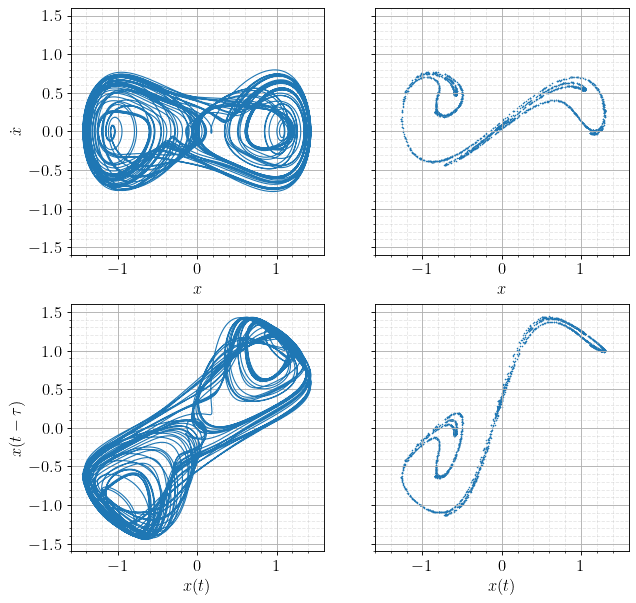

In [232]:
# izris
plt.figure(figsize=(9,9))

# Originalni fazni diagram
plt.subplot(221)
plt.plot(x[0:tmax], xdot[0:tmax], lw=1)
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Originalni Poincaré diagram
plt.subplot(222)
plt.scatter(x[::pstep], xdot[::pstep], s=2, lw=0)
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.xlabel(r'$x$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_ticklabels([])
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Rekonstruiran fazni diagram
plt.subplot(223)
plt.plot(x1[0:tmax], x2[0:tmax], lw=1)
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.xlabel(r'$x(t)$')
plt.ylabel(r'$x(t-\tau)$')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

# Rekonstuiran Poincaré diagram
plt.subplot(224)
plt.scatter(x1[::pstep], x2[::pstep], s=2, lw=0)
plt.xlabel(r'$x(t)$')
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_ticklabels([])
plt.grid(True)
plt.grid(True, which='minor', linestyle = '--', alpha=0.3)

plt.show() 

## Viri ##


1. Moon, F. C., &amp; Holmes, P. J. (1979). *A Magnetoelastic Strange Attractor.* Journal of Sound and Vibration, 65(2), 275–296. https://doi.org/10.1016/0022-460x(79)90520-0 

2. Strogatz, S. (2019). *Nonlinear Dynamics and Chaos: With applications to physics, biology, chemistry, and engineering.* CRC Press, Taylor et Francis Group. 

3. Guckenheimer, J., &amp; Holmes, P. (1983). *Nonlinear oscillations, dynamical systems, and bifurcations of Vector Fields.* Applied Mathematical Sciences, 82–91. https://doi.org/10.1007/978-1-4612-1140-2 

4. *Numerical computation of Lyapunov exponent* https://scicomp.stackexchange.com/questions/36013/numerical-computation-of-lyapunov-exponent